# Tutorial of implementing Variational Auto-Encoder
mnist image에 대하여 Variational Auto-Encoder를 학습하고, mnist image를 Generate 해보는 예제, Encoder는 Gaussian MLP Encoder, Decoder는 Bernoulli MLP Decoder를 활용
  
* Paper 
    * [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf)
    * [Tutorial on Variational Autoencoders](https://arxiv.org/pdf/1606.05908.pdf)
* Reference
    * https://github.com/sjchoi86/advanced-tensorflow/blob/master/ae/vae.ipynb
    * https://github.com/hwalsuklee/tensorflow-mnist-VAE/blob/master/vae.py
    * https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/variational_autoencoder.py
    * https://github.com/ilguyi/vae.tensorflow.slim/blob/master/variational_autoencoder.py

### Setup

In [1]:
import os, sys
import shutil 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data # load mnist dataset
mnist = input_data.read_data_sets(train_dir = './data/MNIST_data/', one_hot = True, reshape = True, seed = 777)

Extracting ./data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST_data/t10k-labels-idx1-ubyte.gz


### Define Variational Auto-Encoder class

In [2]:
class VAE:
    def __init__(self, input_dim = 784, enc_hidden_dims = [100,50], dec_hidden_dims = [50, 100],
                 latent_dim = 2, activation_fn = tf.nn.relu,
                 initializer = tf.contrib.layers.variance_scaling_initializer()):
        
        with tf.variable_scope('encoder_network'): # Gaussian MLP Encoder
            with tf.variable_scope('input_layer'):
                self._x = tf.placeholder(dtype = tf.float32, shape = [None, input_dim])
                _net = self._x

                
            for layer, h_dim in enumerate(enc_hidden_dims):
                with tf.variable_scope('hidden_layer{}'.format(layer+1)):
                    _net = tf.layers.dense(inputs = _net, units = h_dim,
                                           activation = activation_fn,
                                           kernel_initializer = initializer)
                    
            with tf.variable_scope('output_layer'):
                self._z_mu = tf.layers.dense(inputs = _net, units = latent_dim, 
                                          activation = None,
                                          kernel_initializer = initializer, name = 'z_mu')
                
                _z_log_sigma = tf.layers.dense(inputs = _net, units = latent_dim,
                                           activation = None,
                                           kernel_initializer = initializer, name = 'z_log_sigma')
                _z_stddev = tf.exp(_z_log_sigma)

                eps = tf.random_normal(shape = tf.shape(_z_stddev), mean = 0., stddev = 1., dtype = tf.float32)

                # z = mu + sigma * epsilon
                self._z_sample = self._z_mu + _z_stddev * eps

                
        with tf.variable_scope('decoder_network'): # Bernoulli MLP Decoder
            with tf.variable_scope('input_layer'):
                _net = tf.layers.dense(inputs = self._z_sample, units = latent_dim * 2,
                                       activation = activation_fn,
                                       kernel_initializer = initializer)

            for layer, h_dim in enumerate(dec_hidden_dims):
                with tf.variable_scope('hidden_layer{}'.format(layer + 1)):
                    _net = tf.layers.dense(inputs = _net, units = h_dim,
                                           activation = activation_fn,
                                           kernel_initializer = initializer)

            with tf.variable_scope('output_layer'):
                self._xhat = tf.layers.dense(inputs = _net, units = input_dim,
                                             activation = tf.nn.sigmoid)

                
        with tf.variable_scope('loss'):
            _likelihood = tf.reduce_mean(tf.reduce_sum(self._x * tf.log(self._xhat + 1e-10) \
                                         + (1 - self._x) * tf.log(1 - self._xhat) + 1e-10, axis = 1))
            _kl_loss = .5 * tf.reduce_mean(tf.reduce_sum(tf.square(self._z_mu) + tf.square(_z_stddev) \
                                           - tf.log(tf.square(_z_stddev) +1e-10) - 1, axis = 1))
            _elbo = _likelihood - _kl_loss
            self._total_loss = -_elbo
            
    def transform(self, sess, x_data):
        feed_transform = {self._x : x_data}
        return sess.run(self._z_mu, feed_dict = feed_transform)
            
    def reconstruct(self, sess, x_data):
        feed_reconstruct = {self._x : x_data}
        return sess.run(self._xhat, feed_dict = feed_reconstruct)
     
    def generate(self, sess, z):
        feed_generate = {self._z_sample : z}
        return sess.run(self._xhat, feed_dict = feed_generate)   

### Define Solver class

In [3]:
class Solver:
    def __init__(self, model, optimizer = tf.train.AdamOptimizer, var_list = None):
        self._model = model
        self._lr = tf.placeholder(dtype = tf.float32)
        self._optimizer = optimizer(learning_rate = self._lr)
        self._training_op = self._optimizer.minimize(loss = self._model._total_loss, var_list = var_list)
    
    def train(self, sess, x_data, lr):
        feed_train = {self._model._x : x_data, self._lr : lr}
        return sess.run(fetches = [self._training_op, self._model._total_loss], feed_dict = feed_train)
            
    def evaluate(self, sess, x_data):
        feed_loss = {self._model._x : x_data}
        return sess.run(fetches = self._model._total_loss, feed_dict = feed_loss)

### Generate VAE model and Solver

In [4]:
sess = tf.Session()
mnist_generator = VAE(enc_hidden_dims = [100,100], dec_hidden_dims = [100, 100])
adam_solver = Solver(model = mnist_generator)

In [5]:
# Hyper-parameters
batch_size = 100
n_epochs = 40
total_batch = int(mnist.train.num_examples/ batch_size)
tr_loss_history = []

In [6]:
sess.run(tf.global_variables_initializer())

In [7]:
for epoch in range(n_epochs):
    avg_tr_loss = 0
    
    for step in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size = batch_size)
        _, tr_loss = adam_solver.train(sess = sess, x_data = batch_xs, lr = 1e-3)
        avg_tr_loss += tr_loss / total_batch
        
        #if step % 50 == 0:
        #    print('step : {:3}, tr_loss : {:.3f}'.format(step, tr_loss))
    if epoch % 5 == 0:
        print('epoch : {:3}. tr_loss : {:.3f}'.format(epoch, avg_tr_loss))

epoch :   0. tr_loss : 198.656
epoch :   5. tr_loss : 155.425
epoch :  10. tr_loss : 149.696
epoch :  15. tr_loss : 146.767
epoch :  20. tr_loss : 144.815
epoch :  25. tr_loss : 143.287
epoch :  30. tr_loss : 142.276
epoch :  35. tr_loss : 141.618


### Plot reconstruction results

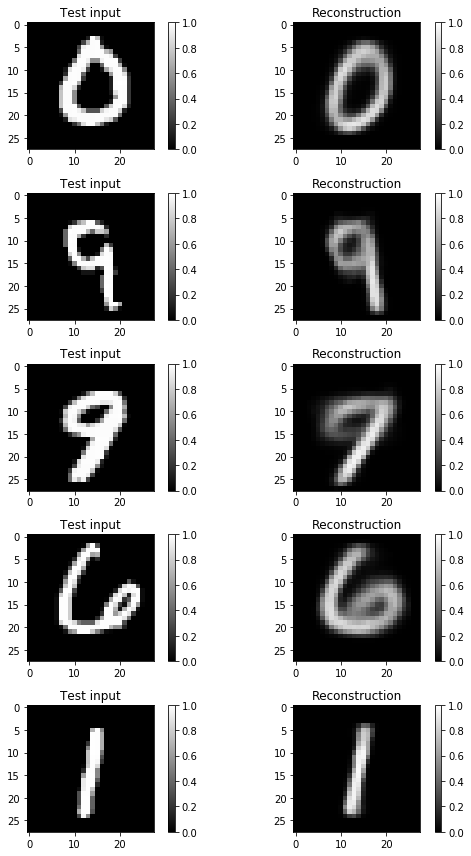

In [8]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = mnist_generator.reconstruct(sess, x_sample)
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

### Plot latent space

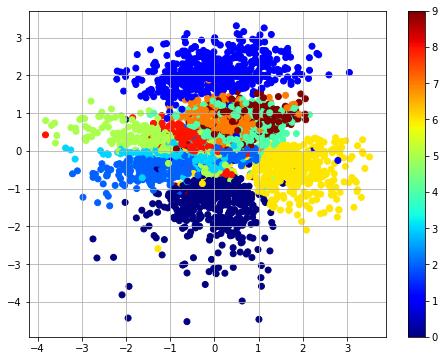

In [9]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = mnist_generator.transform(sess, x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c = np.argmax(y_sample, 1), cmap ='jet')
plt.colorbar()
plt.grid()

### Generate Images while varying two latent variables

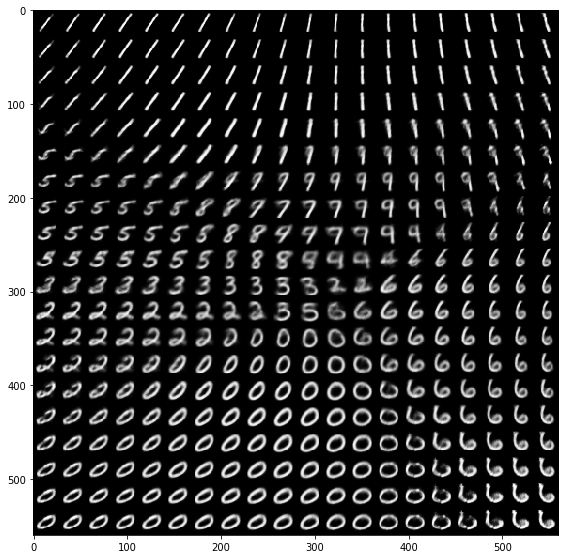

In [10]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((28*ny, 28*nx))

for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]])
        x_mean = mnist_generator.generate(sess, z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()